# Improved One Image Overview for screw-thread

Algorithm is based on draft. Purpose of this notebook:
- clean the previous notebook (move all to python files)
- select different part of raw frame for blending

In [60]:
%cd ..

/Users/gimli/cvr/projects/zavity


In [61]:
import os

import cv2
import imageio.v3 as iio
import numpy as np

import src.pipelines.oio_building_pipeline as oio_builder
from src.config import SRC, FRAMES_PER_360_DEG
from src.steps.video_frame_lightness import VideoLightness

In [62]:
SRC = '/Users/gimli/cvr/data/zavity/Cely_sken_3_110proc'

In [64]:
video_file_path = os.path.join(SRC, "GX010968.MP4")
lightness = VideoLightness(video_file_path)
lightness.process()

vidcap = cv2.VideoCapture(video_file_path)

rows = []
for mn, mx in lightness.rows_frame_no_start_end():
    start = mn + (mx - mn) // 2 - FRAMES_PER_360_DEG // 2
    end = start + FRAMES_PER_360_DEG
    
    row = oio_builder.construct_row(vidcap, start, end)
    rows.append(row)
    iio.imwrite(video_file_path.replace(".MP4", f"-oio-{start}-{end}.png"), row.astype(np.uint8))

Building row image:   0%|          | 0/1946 [00:00<?, ?it/s]

/var/folders/64/59jpvv9x3cb46gv8v_n8n90c0000gn/T/ipykernel_41926/3283184295.py:14: RuntimeWarning: invalid value encountered in cast
  iio.imwrite(video_file_path.replace(".MP4", f"-oio-{start}-{end}.png"), row.astype(np.uint8))


Building row image:   0%|          | 0/1946 [00:00<?, ?it/s]

Building row image:   0%|          | 0/1946 [00:00<?, ?it/s]

Building row image:   0%|          | 0/1946 [00:00<?, ?it/s]

Building row image:   0%|          | 0/1946 [00:00<?, ?it/s]

Building row image:   0%|          | 0/1946 [00:00<?, ?it/s]

Building row image:   0%|          | 0/1946 [00:00<?, ?it/s]

## Row Stitching

In [46]:
# physical constants
SHIFT_PER_FRAME = 13.95 # number of pixels for which are shifted two consecutive frames (depends on camera speed)
BLENDED_PIXELS_PER_FRAME = 20 # number of pixels taken from one image (volatile, must be greater than SHIFT_PER_FRAME)
FRAME_SIZE = (2160, 3840) # size of the frame (GoPro setup)
FRAMES_PER_360_DEG = 1946 # number of frames per 360 deg (depends on camera speed)

In [36]:
print("Light on at: ", light_on[0])
print("Light off at: ", light_off[0])

Light on at:  [   67  2624  4874  7457  9957 12417 14805]
Light off at:  [    6  2206  4766  7018  9596 12099 14558 16942]


In [37]:
rows = list(zip(light_on[0], light_off[0][1:]))

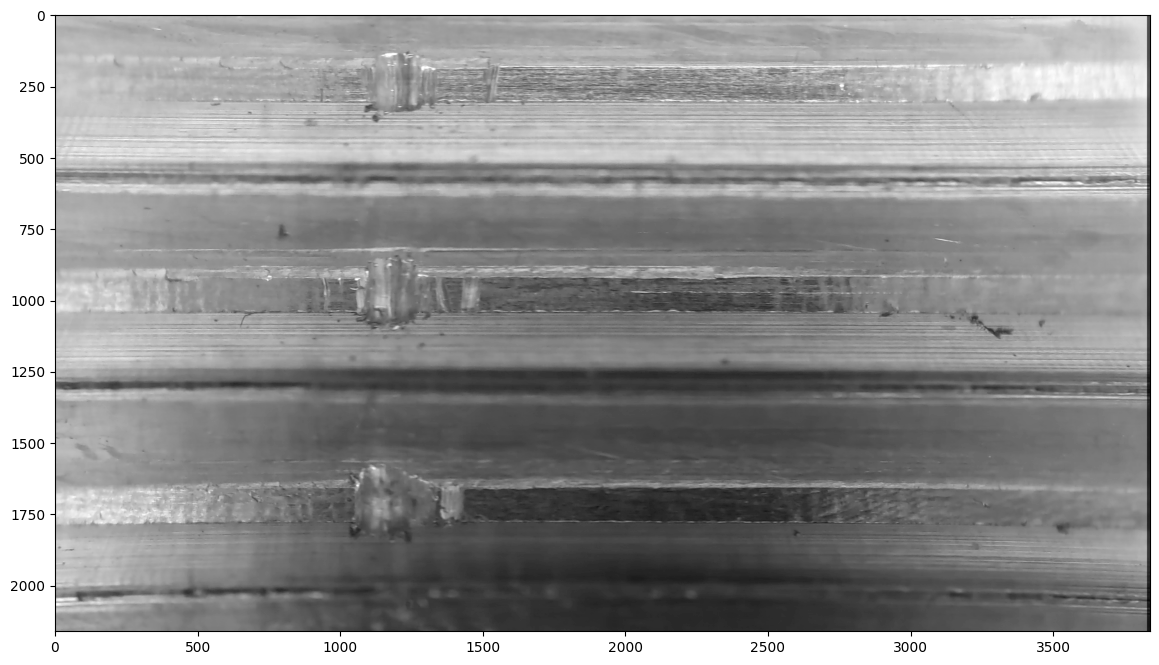

In [38]:
plt.figure(figsize=(15,8))

# ax = plt.subplot(121)
# ax.imshow(a, cmap="gray")
M = np.float32([
            [1, 0, (-SHIFT_PER_FRAME)],
            [0, 1, 0]
        ])
ax = plt.subplot(111)
ax.imshow((cv2.warpAffine(a1, M, (a1.shape[1], a1.shape[0])).astype(float) + a.astype(float))[:,:,0] // 2, cmap="gray")

plt.show()

In [55]:
def construct_oio(vidcap, start, end, direction: str = "CCW", shift_per_frame=SHIFT_PER_FRAME, blended_pixels_per_frame=BLENDED_PIXELS_PER_FRAME):
    if not vidcap or end - start <= 0:
        raise IOError("Unsupported input data.")
    
    # pixel intensity accumulator
    row_image = np.zeros((FRAME_SIZE[0], np.ceil(FRAMES_PER_360_DEG * shift_per_frame).astype(int) + FRAME_SIZE[1] // 2))
    # weight matrix for the accumulator
    weight_matrix = np.zeros(row_image.shape)
    
    vidcap.set(cv2.CAP_PROP_POS_FRAMES, start)
    
    for frameNo in tqdm(range(0, end - start)):
        _, image = vidcap.read()
        shift = (row_image.shape[1] - shift_per_frame * frameNo) if direction == "CCW" else (shift_per_frame * frameNo)                                        
        M = np.float32([
                [1, 0, shift],
                [0, 1, 0]
            ])
        
        aligned_image = np.fliplr(cv2.warpAffine(image, M, (row_image.shape[1], row_image.shape[0])))
        
        # we take column from the middle of the frame
        crop_x_start = (np.round(row_image.shape[1] - shift_per_frame * frameNo - image.shape[1] // 2 - blended_pixels_per_frame // 2).astype(int) 
                        if direction == "CCW" 
                        else np.round(shift_per_frame * frameNo + image.shape[1] // 2 - blended_pixels_per_frame // 2).astype(int))
        crop_x_end = np.max([0, crop_x_start + blended_pixels_per_frame])
        row_image[:, crop_x_start:crop_x_end] += aligned_image[:, crop_x_start:crop_x_end, 0]
        weight_matrix[:, crop_x_start:crop_x_end] += 1
        
    return np.copy((row_image / weight_matrix)[
       :, 
       image.shape[1] // 2 - blended_pixels_per_frame // 2: - blended_pixels_per_frame // 2] # crop the empty space
    )

In [56]:
## Build OIOs
for mn, mx in tqdm(rows[:1]):
    vidcap = cv2.VideoCapture(os.path.join(SRC, videos[0]))
    
    # mn and mx are 110% of the one row, we cut the first and last 5% of the row
    start = mn + (mx - mn) // 2 - FRAMES_PER_360_DEG // 2 
    end = start + FRAMES_PER_360_DEG 
    
    # build oio
    oio = construct_oio(vidcap, start, end, "CCW")
    iio.imwrite(os.path.join(SRC, f"oio-{mn}-{mx}.png"), oio.astype(np.uint8))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]

/var/folders/64/59jpvv9x3cb46gv8v_n8n90c0000gn/T/ipykernel_41926/1178983251.py:30: RuntimeWarning: invalid value encountered in divide
  return np.copy((row_image / weight_matrix)[
/var/folders/64/59jpvv9x3cb46gv8v_n8n90c0000gn/T/ipykernel_41926/2848913626.py:11: RuntimeWarning: invalid value encountered in cast
  iio.imwrite(os.path.join(SRC, f"oio-{mn}-{mx}.png"), oio.astype(np.uint8))


In [57]:
oio

array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]])

## Load images

In [4]:
rows_images = []
for filename in sorted(os.listdir(SRC)):
    if "zavit" in filename and "png" in filename:
        rows_images.append(iio.imread(os.path.join(SRC, filename)))

In [5]:
# registration by mutual information
def mutual_information(imgA, imgB, bins=15):
    # taken from https://matthew-brett.github.io/teaching/mutual_information.html    
    hist_2d, x_edges, y_edges = np.histogram2d(
         imgA.ravel(),
         imgB.ravel(),
         bins=bins
    )
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def extract_images_and_compute_mi(shift, imgA, imgB, seed_position):    
    x = np.arange(seed_position[1, 0] + shift[0], seed_position[1, 0] + shift[0] + 399.5)
    y = np.arange(seed_position[1, 1] + shift[1], seed_position[1, 1] + shift[1] + 599.5)    
    xg, yg = np.meshgrid(x, y)
    interp = RegularGridInterpolator((np.arange(imgB.shape[0]), np.arange(imgB.shape[1])), imgB)
    return -mutual_information(
        imgA[seed_position[0, 0]: seed_position[0, 0] + 400, 
             seed_position[0, 1]: seed_position[0, 1] + 600].T,         
        interp((xg, yg))
    )

def to_minimize(x):
    return extract_images_and_compute_mi(shift=x, imgA=imgA, imgB=imgB, seed_position=seed_position)

def show_images(imgA, imgB, seed_position, shift):
    plt.figure(figsize=(15,5))
    ax = plt.subplot(131)
    ax.imshow(imgA[seed_position[0, 0]: seed_position[0, 0] + 400, 
                   seed_position[0, 1]: seed_position[0, 1] + 600].T, cmap="gray")
    ax.set_title("Fixed")

    x = np.arange(seed_position[1, 0] + shift[0], seed_position[1, 0] + shift[0] + 399.5)
    y = np.arange(seed_position[1, 1] + shift[1], seed_position[1, 1] + shift[1] + 599.5)    
    xg, yg = np.meshgrid(x, y)
    interp = RegularGridInterpolator((np.arange(imgB.shape[0]), np.arange(imgB.shape[1])), imgB)
    
    ax = plt.subplot(132)
    ax.imshow(interp((xg, yg)), cmap="gray")
    ax.set_title("Moved")

    ax = plt.subplot(133)
    ax.imshow(imgA[seed_position[0, 0]: seed_position[0, 0] + 400, 
                   seed_position[0, 1]: seed_position[0, 1] + 600].T + interp((xg, yg)), cmap="gray")
    ax.set_title("Blend")
    plt.show()
               

In [6]:
physics = {
    "roll":  np.round(rows_images[0].shape[1] * 0.1).astype(int) + 40,
    "scan_shift": 2160 // 2 + 30,
    "screw_thread_distance": 400,
    "first_frame": [1600, 26400]
}

In [7]:
first_frame = physics["first_frame"]
scan_shift = physics["scan_shift"]
roll = physics["roll"]

seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] - roll]]).astype(int)
imgA = rows_images[0]
imgB = rows_images[1]
s1 = minimize(to_minimize, x0=[0, 0], method='COBYLA', bounds=[(-10, +10),(-10, 10)])

/Users/gimli/Applications/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [8]:
s1

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.3092492164469124
       x: [ 1.734e+00 -7.054e-01]
    nfev: 27
   maxcv: 0.0

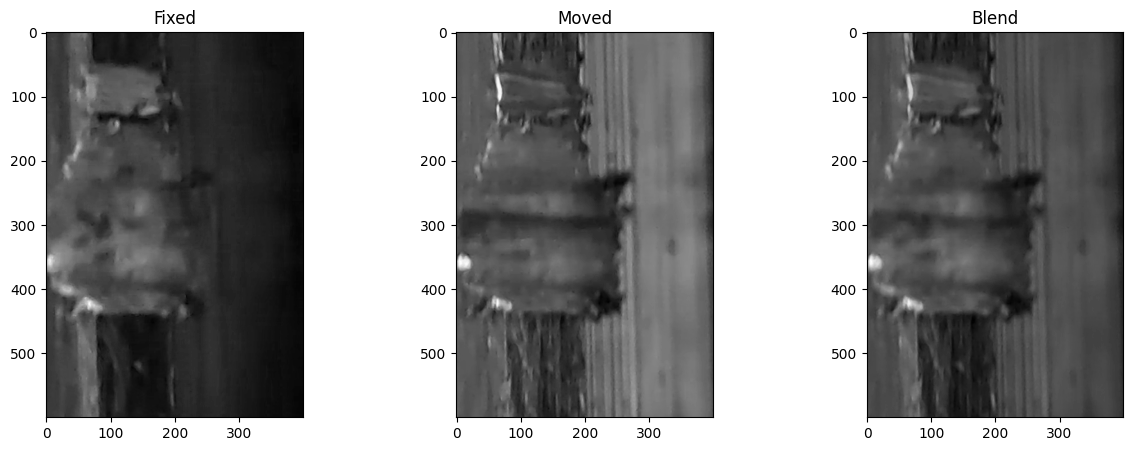

In [9]:
show_images(imgA, imgB, seed_position, s1.x)

In [10]:
screw_thread_distance = physics["screw_thread_distance"]
seed_position = np.array([[first_frame[0] - scan_shift + 2 * screw_thread_distance, first_frame[1] - roll],
                          [first_frame[0] - 2 * scan_shift + 2 * screw_thread_distance, first_frame[1] - 2 * roll]]).astype(int)
imgA = rows_images[1]
imgB = rows_images[2]
s2 = minimize(to_minimize, x0=[0,30], method='COBYLA', bounds=[(-10, 10),(-10, 40)])

In [11]:
s2

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.4046245733262187
       x: [ 1.145e+01  2.604e+01]
    nfev: 51
   maxcv: 0.0

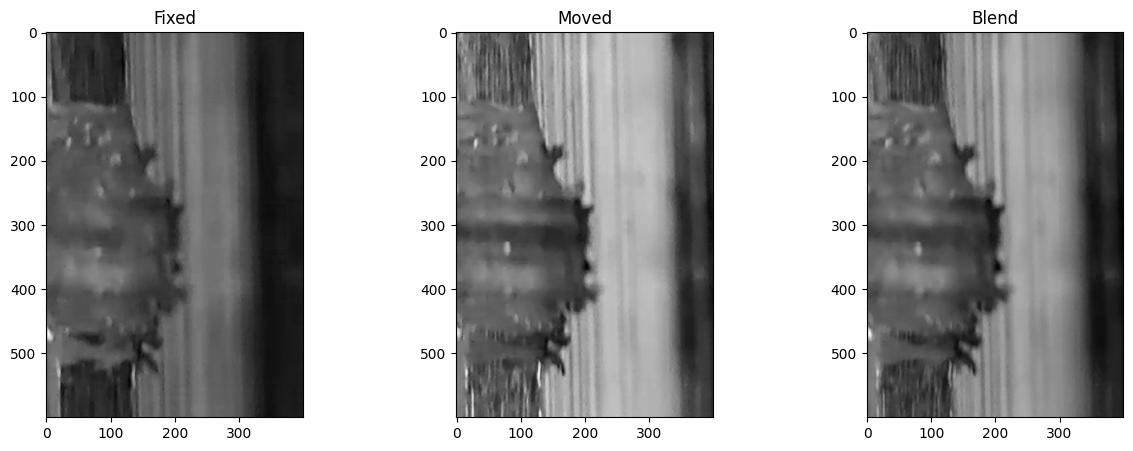

In [12]:
show_images(imgA, imgB, seed_position, s2.x)

In [18]:
[[first_frame[0] - 2 * scan_shift + 5 * screw_thread_distance, first_frame[1] - 2 * roll], [first_frame[0] - 3 * scan_shift + 5 * screw_thread_distance, first_frame[1] - 3 * roll]]

[[1380, 20892], [270, 18138]]

In [60]:
seed_position = np.array([[first_frame[0] - 2 * scan_shift + 5 * screw_thread_distance, first_frame[1] - 2 * roll],
                          [first_frame[0] - 3 * scan_shift + 5 * screw_thread_distance, first_frame[1] - 3 * roll]]).astype(int)
imgA = rows_images[2]
imgB = rows_images[3]
s3 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [61]:
s3

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.24908655576305255
       x: [ 7.225e+00  2.053e+01]
     nit: 4
   direc: [[ 1.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00]]
    nfev: 185

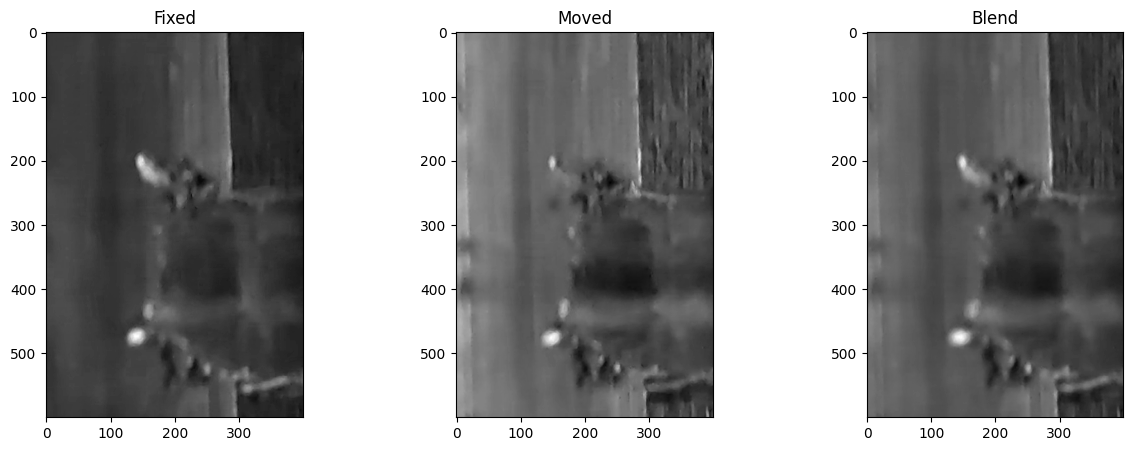

In [62]:
show_images(imgA, imgB, seed_position, s3.x)

In [55]:
[[first_frame[0] - 3 * scan_shift + 9 * screw_thread_distance, first_frame[1] - 3 * roll],
                          [first_frame[0] - 4 * scan_shift + 9 * screw_thread_distance, first_frame[1] - 4 * roll]]

[[1870, 18138], [760, 15384]]

In [57]:
seed_position = np.array([[first_frame[0] - 3 * scan_shift + 8 * screw_thread_distance, first_frame[1] - 3 * roll],
                          [first_frame[0] - 4 * scan_shift + 8 * screw_thread_distance, first_frame[1] - 4 * roll]]).astype(int)
imgA = rows_images[3]
imgB = rows_images[4]
s4 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [58]:
s4

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.6119628831609565
       x: [ 9.438e+00  1.440e+01]
     nit: 3
   direc: [[ 0.000e+00  1.000e+00]
           [-4.237e-01 -6.594e-01]]
    nfev: 161

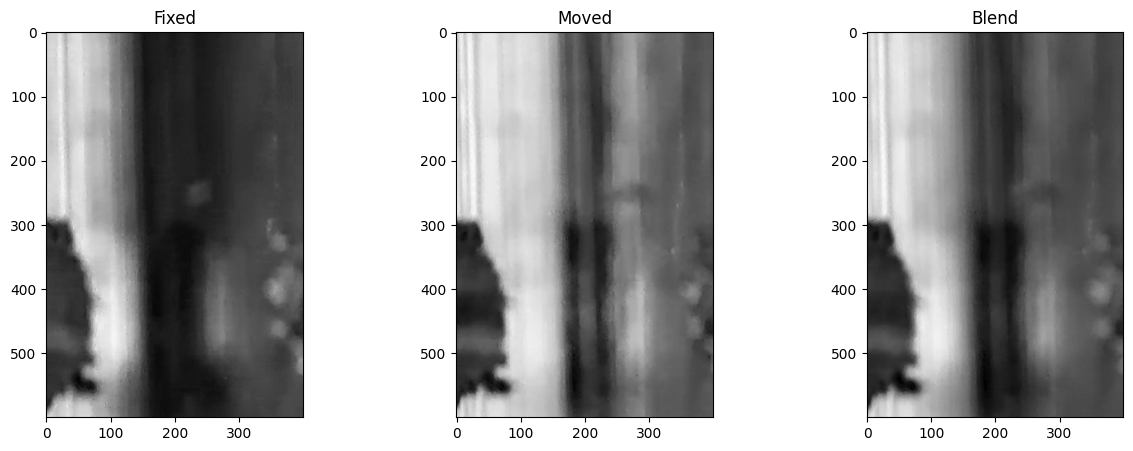

In [59]:
show_images(imgA, imgB, seed_position, s4.x)

In [67]:
[[first_frame[0] - 4 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 4 * roll],
 [first_frame[0] - 5 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 5 * roll]]

[[1560, 15384], [450, 12630]]

In [76]:
seed_position = np.array([[first_frame[0] - 4 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 4 * roll],
                          [first_frame[0] - 5 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 5 * roll]]).astype(int)
imgA = rows_images[4]
imgB = rows_images[5]
s5 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [77]:
s5

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.8232195893043974
       x: [ 8.226e+00  2.280e+01]
     nit: 4
   direc: [[ 4.318e-01  1.267e+00]
           [ 5.465e-02  4.680e-02]]
    nfev: 251

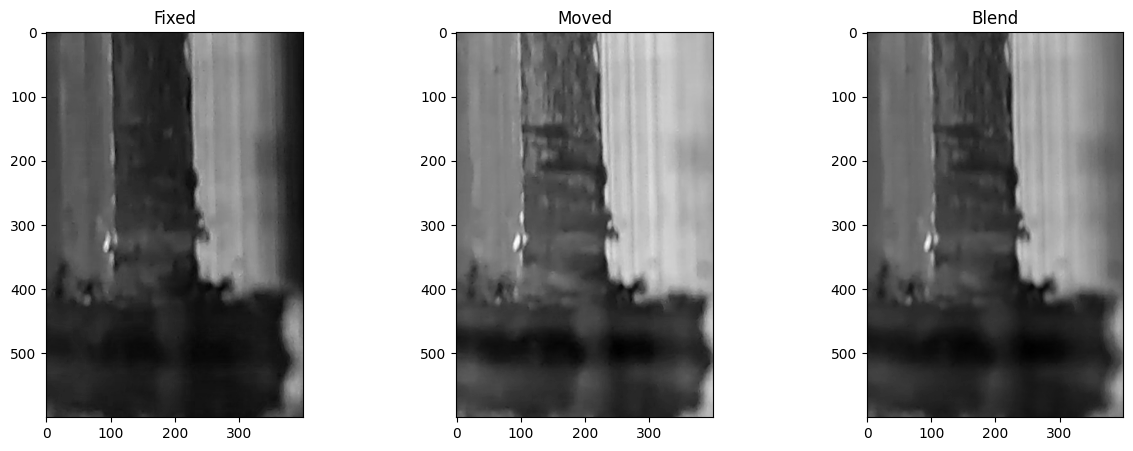

In [78]:
show_images(imgA, imgB, seed_position, s5.x)

In [71]:
[[first_frame[0] - 5 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 5 * roll],
 [first_frame[0] - 6 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 6 * roll]]

[[1250, 12630], [140, 9876]]

In [73]:
seed_position = np.array([[first_frame[0] - 5 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 5 * roll],
                          [first_frame[0] - 6 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 6 * roll]]).astype(int)
imgA = rows_images[5]
imgB = rows_images[6]
s6 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [74]:
s6

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.7742417336289078
       x: [ 7.514e+00 -8.945e+00]
     nit: 3
   direc: [[ 0.000e+00  1.000e+00]
           [-8.752e-01  9.716e-01]]
    nfev: 172

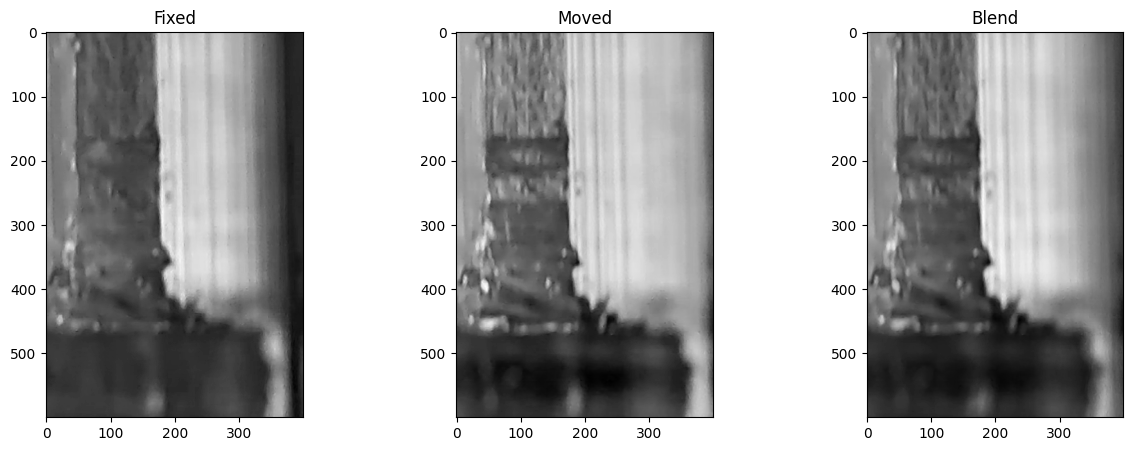

In [75]:
show_images(imgA, imgB, seed_position, s6.x)

In [84]:
shift_fixes = np.array([s1.x, s2.x, s3.x, s4.x, s5.x, s6.x])

## Merge

- sesbírat posun per row
- aggregovats `sn.x`
- provést roll každé otočky + interpolaci
- vyrobit váhovou matici pro překryv
- vynásobit / flatnout

In [81]:
shift_seed = []
shift_seed.append(np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] - roll]]).astype(int))
shift_seed.append(np.array([[first_frame[0] - scan_shift + 2 * screw_thread_distance, first_frame[1] - roll],
                            [first_frame[0] - 2 * scan_shift + 2 * screw_thread_distance, first_frame[1] - 2 * roll]]).astype(int))
shift_seed.append(np.array([[first_frame[0] - 2 * scan_shift + 5 * screw_thread_distance, first_frame[1] - 2 * roll],
                            [first_frame[0] - 3 * scan_shift + 5 * screw_thread_distance, first_frame[1] - 3 * roll]]).astype(int))
shift_seed.append(np.array([[first_frame[0] - 3 * scan_shift + 8 * screw_thread_distance, first_frame[1] - 3 * roll],
                            [first_frame[0] - 4 * scan_shift + 8 * screw_thread_distance, first_frame[1] - 4 * roll]]).astype(int))
shift_seed.append(np.array([[first_frame[0] - 4 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 4 * roll],
                            [first_frame[0] - 5 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 5 * roll]]).astype(int))
shift_seed.append(np.array([[first_frame[0] - 5 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 5 * roll],
                            [first_frame[0] - 6 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 6 * roll]]).astype(int))

In [87]:
per_row_shift = np.array([seed[0, :] - seed[1, :] - fix for seed, fix in zip(shift_seed, shift_fixes)])

In [89]:
per_row_shift

array([[1108.26623393, 2754.70537754],
       [1098.55157921, 2727.96337104],
       [1102.77542198, 2733.46959145],
       [1100.56230889, 2739.59806014],
       [1101.77433941, 2731.19967697],
       [1102.48623819, 2762.94508227]])

In [112]:
def real_roll(array, shift, axis=0):    
        double_image = np.concatenate([array, array], axis=1)
    interp = RegularGridInterpolator(
        (np.arange(double_image.shape[0]), np.arange(double_image.shape[1])), 
        double_image
    )
    if shift > 0:
        y = np.arange(shift, shift + array.shape[1] - 0.5, 1)
    else:
        y = np.arange(shift + array.shape[1], 2 * array.shape[1] + shift - 0.5, 1)    
    x = np.arange(array.shape[0])    
    xg, yg = np.meshgrid(x, y)    
    return interp((xg, yg)).T

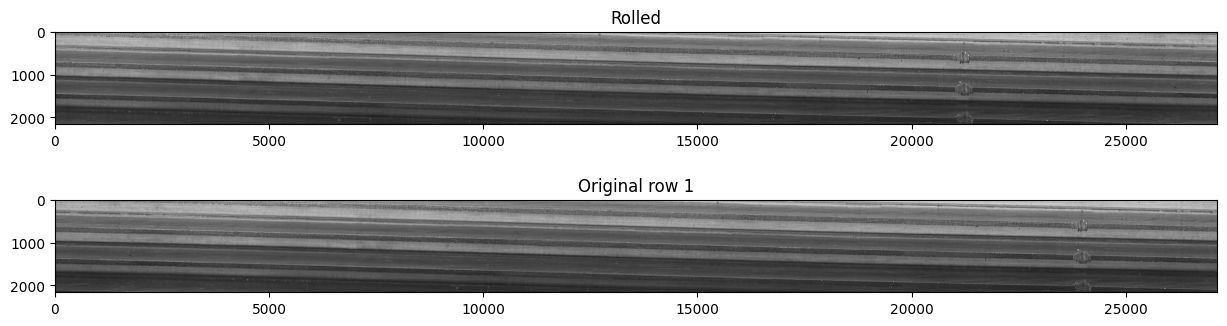

In [114]:
# Test of the real roll function
plt.figure(figsize=(15,4))
ax = plt.subplot(211)
ax.imshow(real_roll(rows_images[1], per_row_shift[0,1]), cmap="gray")
ax.set_title("Rolled")
ax = plt.subplot(212)
ax.imshow(rows_images[1], cmap="gray")
ax.set_title("Original row 1")
plt.show()

In [119]:
rows_images[0].shape

(2160, 27137)

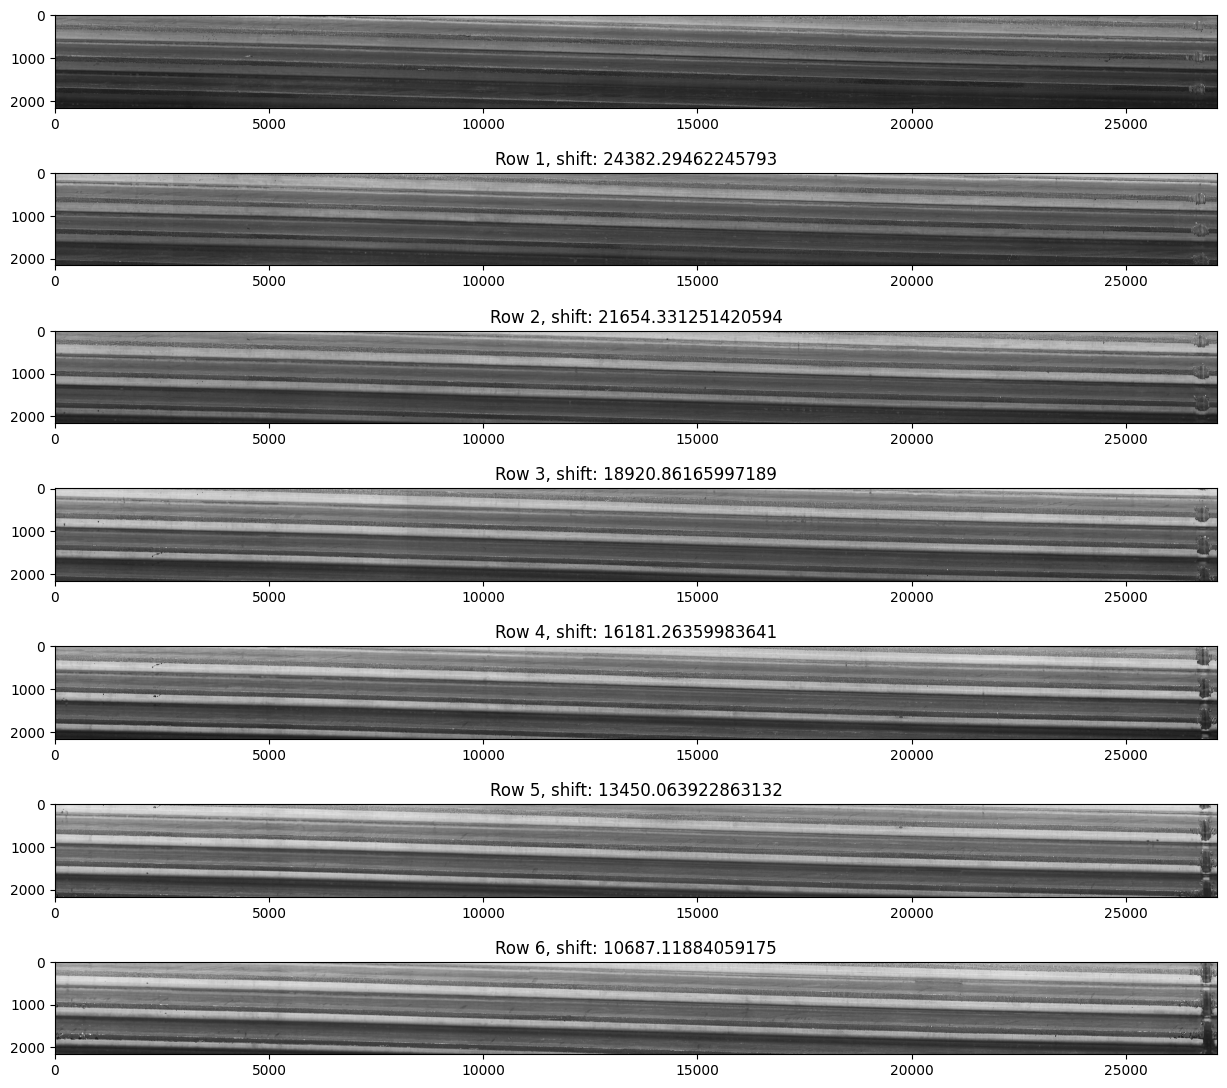

In [170]:
rolled = []
# Roll all rows as required and plot them
plt.figure(figsize=(15,14))
ax = plt.subplot(7, 1, 1)
ax.imshow(rows_images[0], cmap="gray")
rolled.append(rows_images[0])
for en, row_shift in enumerate(np.cumsum(-per_row_shift[:,1])):
    ax = plt.subplot(7, 1, en+2)
    rolled.append(real_roll(rows_images[en + 1], row_shift % rows_images[en + 1].shape[1]))
    ax.imshow(rolled[-1], cmap="gray")
    ax.set_title(f"Row {en + 1}, shift: {row_shift % rows_images[en + 1].shape[1]}")
plt.show()

In [171]:
# merge rows

In [179]:
to_grid = [rolled[0]]
real_shift = [0]
for image, shift in tqdm(zip(rolled[1:], np.cumsum(per_row_shift[:,0])), total=per_row_shift.shape[0]):
    interp = RegularGridInterpolator(
        (np.arange(image.shape[0]), np.arange(image.shape[1])), 
        image
    )
    x = np.arange(image.shape[0] - 1)
    y = np.arange(image.shape[1])
    xg, yg = np.meshgrid(x,y)
    to_grid.append(interp((xg, yg)).T)
    real_shift.append(int(shift // 1))


  0%|          | 0/6 [00:00<?, ?it/s]

In [194]:
out_height = rolled[0].shape[0] + np.max(real_shift)

In [195]:
full_image = np.zeros((out_height, rolled[0].shape[1], len(rolled)))
for en, (image, r_shift) in enumerate(zip(to_grid, real_shift)):
    full_image[r_shift: r_shift + image.shape[0], :, en] = image

In [248]:
blend_matrix = np.zeros((out_height, to_grid[0].shape[1], len(to_grid)))

blend_matrix[:real_shift[1], :, 0] += 1
lin_blend = np.dot(np.arange(0, 1, 1/(to_grid[0].shape[0] - real_shift[1])).reshape(-1, 1), 
                   np.ones((to_grid[0].shape[1],1)).T)
blend_matrix[real_shift[1]: to_grid[0].shape[0], :, 0] += np.flipud(lin_blend)
blend_matrix[real_shift[1]: to_grid[0].shape[0], :, 1] += lin_blend

for en, (image, r_shift) in enumerate(list(zip(to_grid, real_shift))[:-2]):
    blend_matrix[real_shift[en] + to_grid[en].shape[0]: real_shift[en + 2], :, en + 1] += 1
    lin_blend = np.dot(np.arange(0, 1, 1/(to_grid[en + 1].shape[0] + real_shift[en + 1] - real_shift[en + 2])).reshape(-1, 1), 
                       np.ones((to_grid[en + 1].shape[1],1)).T)
    blend_matrix[real_shift[en + 2]: to_grid[en + 1].shape[0] + real_shift[en + 1], :, en + 1] += np.flipud(lin_blend)
    blend_matrix[real_shift[en + 2]: to_grid[en + 1].shape[0] + real_shift[en + 1], :, en + 2] += lin_blend

blend_matrix[to_grid[en + 1].shape[0] + real_shift[en + 1]:, :, -1] += 1

In [260]:
blended_full_image = np.sum(full_image * blend_matrix, axis=2) / np.sum(blend_matrix, axis=2)

## Conclusion - Image READY

In [263]:
iio.imwrite(os.path.join(SRC, "oio.png"), blended_full_image.astype(np.uint8))

# Rotate to diff

In [269]:
edges = cv2.Canny(blended_full_image.astype(np.uint8),80,200)

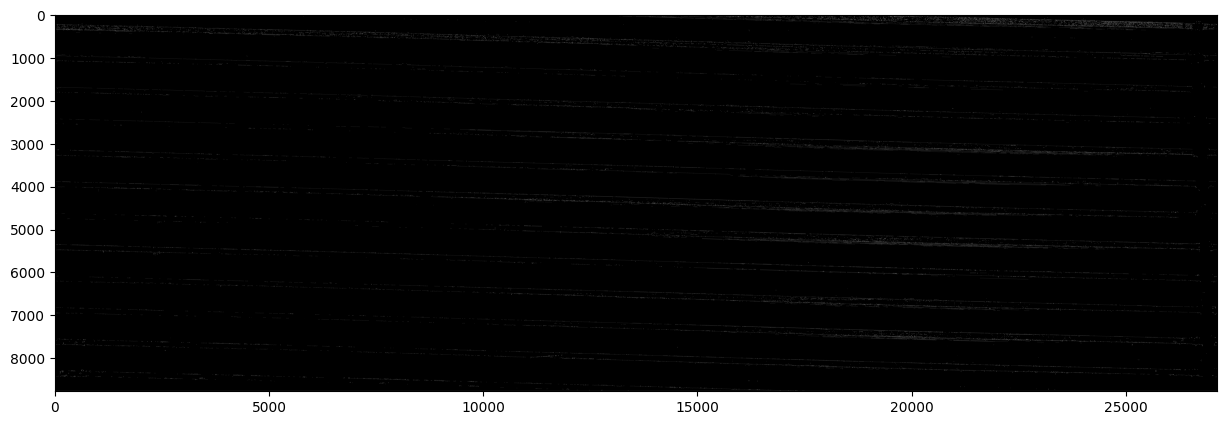

In [270]:
plt.figure(figsize=(15,8))
plt.imshow(edges, cmap="gray")
plt.show()

In [285]:
lines = cv2.HoughLines(edges, 10, np.pi/1800, 1, min_theta=4/5 * np.pi, max_theta=np.pi)


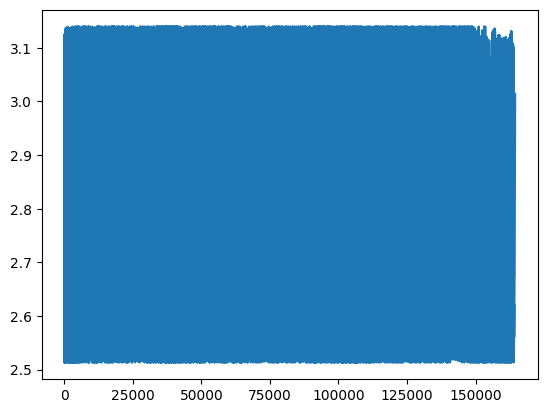

In [286]:
plt.plot(lines[:,0,1])
plt.show()

### Odbočka - copak je v GPMF datech

In [106]:
import gpmf
from scipy.ndimage import gaussian_filter1d as gaussian
from scipy.signal import butter, sosfilt

In [31]:
gpmf_stream = gpmf.io.extract_gpmf_stream(os.path.join(SRC, videos[0]))

In [32]:
stream_content = []
for s in gpmf.parse.filter_klv(gpmf_stream, "GYRO"):
    content = []
    is_gyro = False
    for elt in s.value:
        content.append(elt)
        
    stream_content.append(content)

In [33]:
len(stream_content) * 207

42849

In [35]:
len(stream_content[0])

201

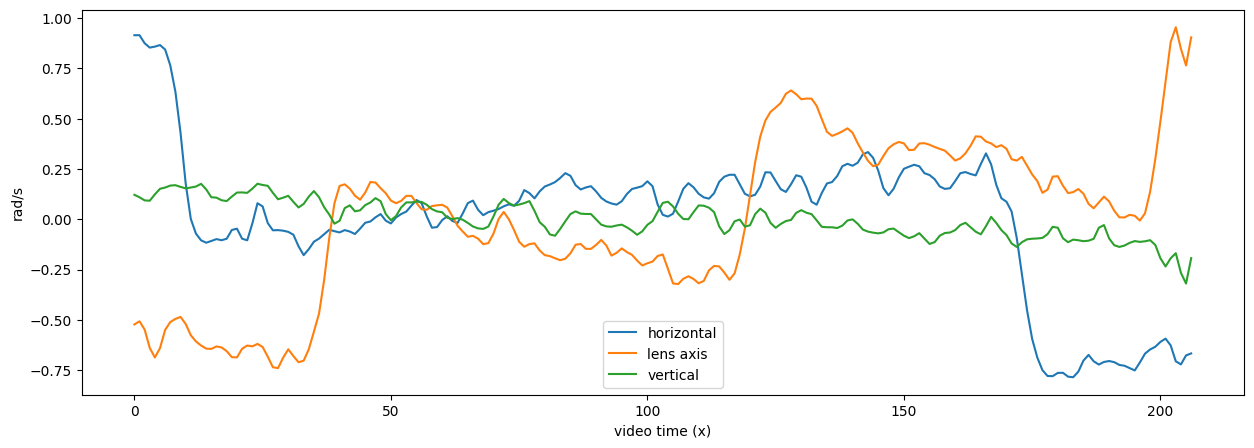

In [50]:
plt.figure(figsize=(15,5))
ax=plt.subplot(111)
x = gaussian([np.mean([x for x, _, _ in content]) for content in stream_content], 1)
ax.plot(x - np.mean(x), label="horizontal")
y = gaussian([np.mean([x for _, x, _ in content]) for content in stream_content], 1)
ax.plot(y - np.mean(y), label="lens axis")
z = gaussian([np.mean([x for _, _, x in content]) for content in stream_content], 1)
ax.plot(z - np.mean(z), label="vertical")
plt.ylabel("rad/s")
plt.xlabel("video time (x)")
plt.legend()
plt.show()

In [51]:
from pykalman import KalmanFilter

In [89]:
kf = KalmanFilter(n_dim_obs=1, em_vars=['transition_covariance', 'observation_covariance', 'initial_state_mean'])

TypeError: only length-1 arrays can be converted to Python scalars

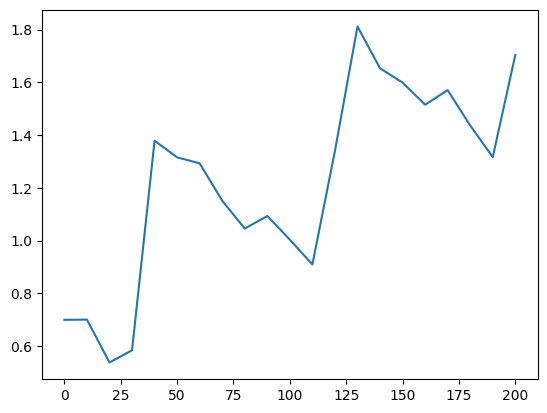

In [98]:
plt.plot(np.arange(0, len(y), 10), kf.em(y, n_iter=10).smooth(y[::10])[0].reshape(-1))
plt.plot(buttap(y))
plt.show()

In [161]:
sos = butter(1, 60, 'hp', fs=1000, output='sos')
filtered = sosfilt(sos, y)

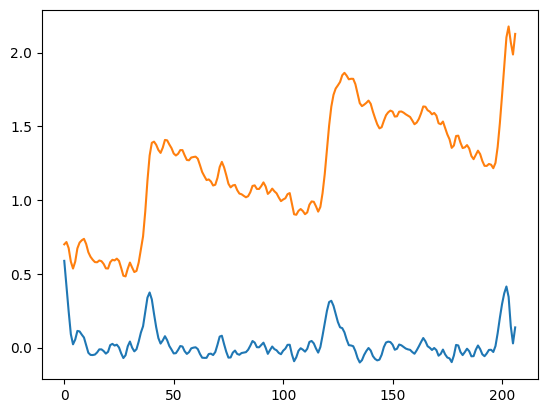

In [162]:
plt.plot(filtered)
plt.plot(y)
plt.show()